Richa_Modi - Pietro_Servadio - Vasu_Bansal - Assignment9

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

170498071/170498071 [==============================] - 4s 0us/step
6


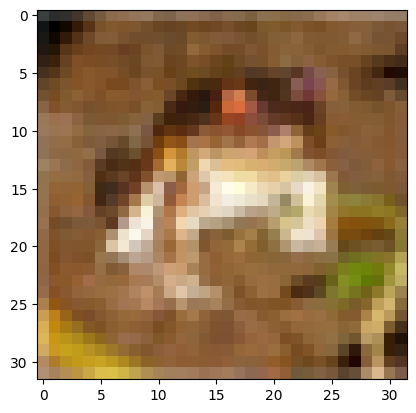

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# CIFAR labels for some reason are [N, 1] instead of just [N,] so we reshape them
train_labels = train_labels.reshape(-1).astype(np.int32)
test_labels = test_labels.reshape(-1).astype(np.int32)

train_images = train_images.astype(np.float32) / 255
test_images = test_images.astype(np.float32) / 255

print(train_labels[0])
plt.imshow(train_images[0])
plt.show()

train_data = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels))
train_data = train_data.shuffle(buffer_size=60000).batch(128)

test_data = tf.data.Dataset.from_tensor_slices(
    (test_images, test_labels)).batch(128)

In [4]:
# here's an example for a better definition.
# I also included 1x1 convolutions as in the actual inception architecture.
def inception_block(inputs, n_filters):
    conv1_1 = tf.keras.layers.Conv2D(n_filters, 1, activation=tf.nn.relu, padding="same")(inputs)

    conv1_3 = tf.keras.layers.Conv2D(n_filters, 1, padding="same")(inputs)
    conv1_3 = tf.keras.layers.Conv2D(n_filters, 3, activation=tf.nn.relu, padding="same")(conv1_3)

    conv1_5 = tf.keras.layers.Conv2D(n_filters, 1, padding="same")(inputs)
    conv1_5 = tf.keras.layers.Conv2D(n_filters, 5, activation=tf.nn.relu, padding="same")(conv1_5)

    pool1 = tf.keras.layers.MaxPool2D(3, 1, padding="same")(inputs)
    pool1 = tf.keras.layers.Conv2D(n_filters, 1, padding="same")(pool1)

    concat1 = tf.concat([conv1_1, conv1_3, conv1_5, pool1], axis=-1)

    return concat1


# it's easy to build a deeper model that way.
inputs = tf.keras.layers.Input((32, 32, 3))

blocks_per_resolution = 2
filters = [32, 64, 128]

x = inputs
for n_filters in filters:
    for block in range(blocks_per_resolution):
        x = inception_block(x, n_filters)
    # downsample
    x = tf.keras.layers.MaxPool2D(padding="same")(x)

pooled = tf.keras.layers.GlobalAveragePooling2D()(x)
logits = tf.keras.layers.Dense(10)(pooled)

model = tf.keras.Model(inputs, logits, name="inception")

print(model.summary())

Model: "inception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 32)           128       ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 32, 32, 32)           128       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 3)            0         ['input_1[0][0]']             
 D)                                                                                       

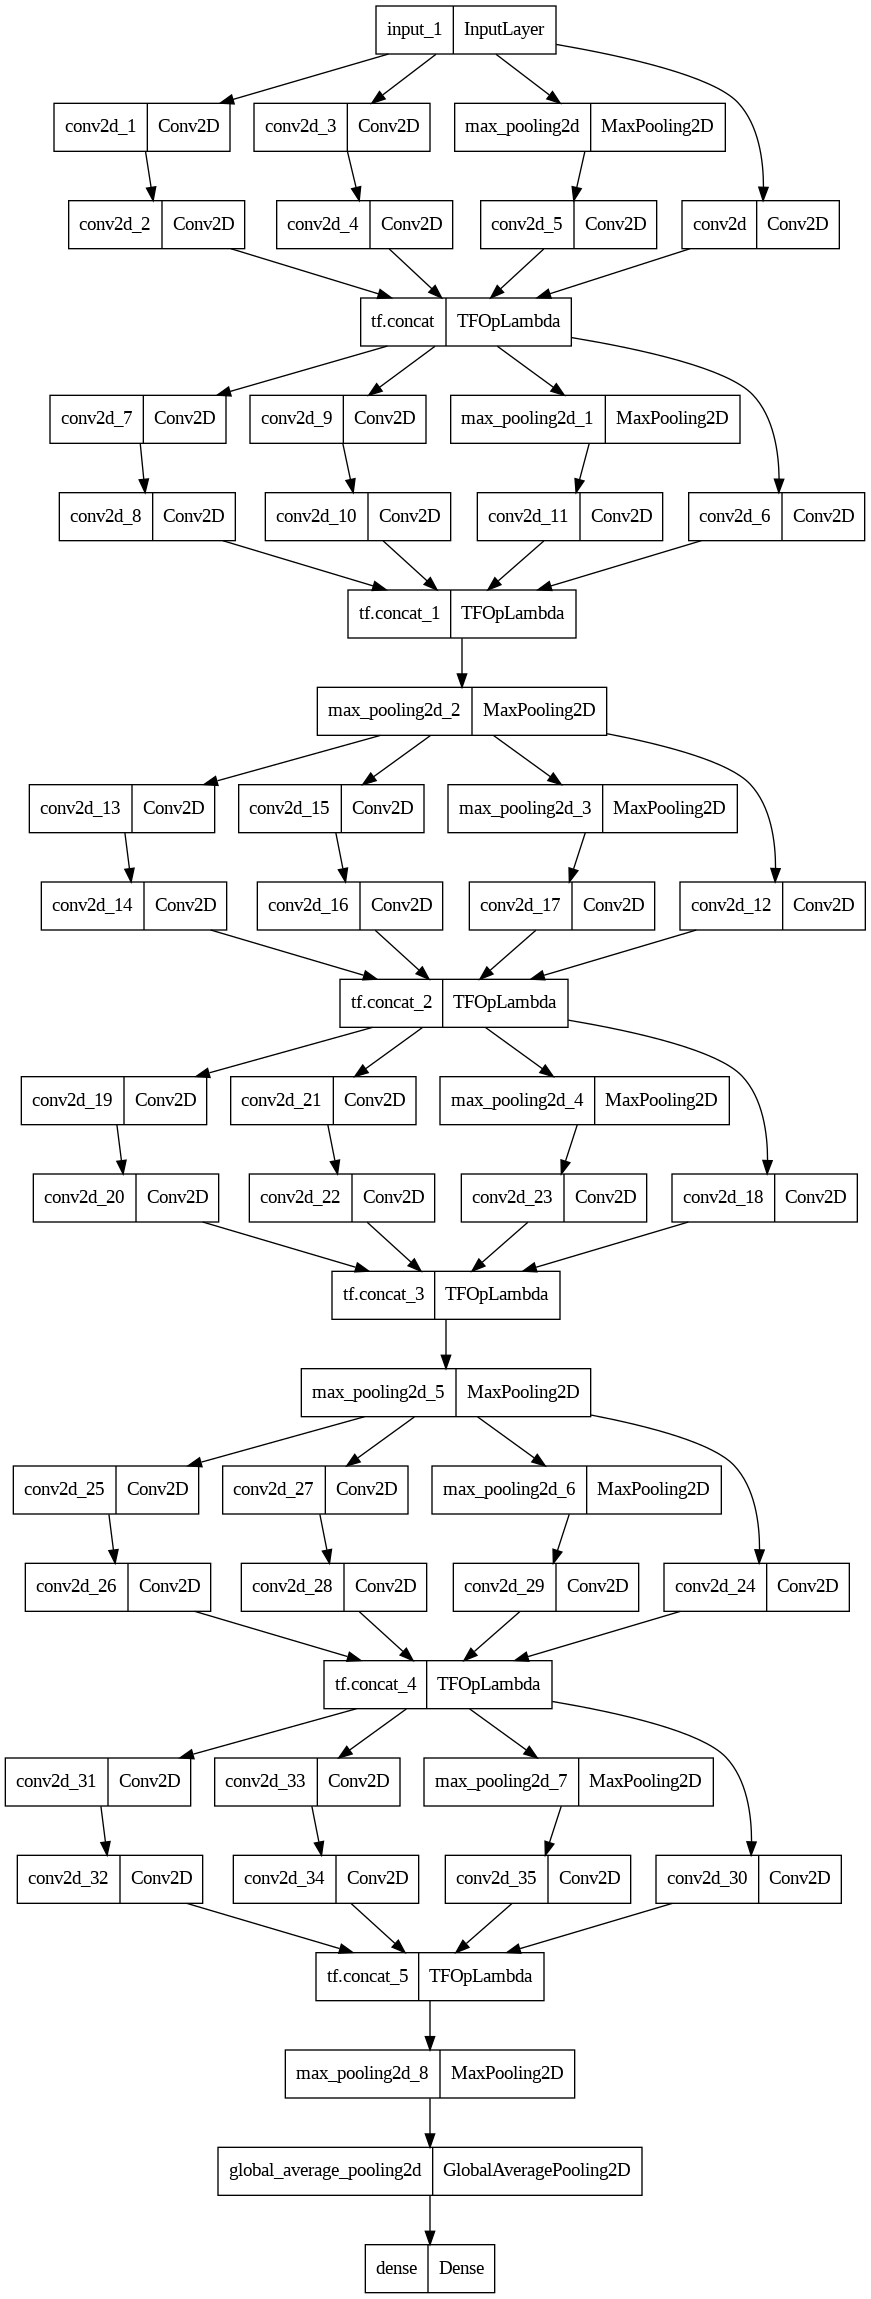

In [5]:
tf.keras.utils.plot_model(model)

In [23]:
optimizer = tf.optimizers.Adam()
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy_metric = tf.metrics.SparseCategoricalAccuracy()

# jit_compile can give a significant speed-up and improves memory usage
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[accuracy_metric],
              jit_compile=True)

In [ ]:
model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
391/391 [==============================] - 70s 117ms/step - loss: 1.5473 - sparse_categorical_accuracy: 0.4282 - val_loss: 1.1591 - val_sparse_categorical_accuracy: 0.5825
Epoch 2/10
391/391 [==============================] - 31s 80ms/step - loss: 0.9804 - sparse_categorical_accuracy: 0.6535 - val_loss: 0.8729 - val_sparse_categorical_accuracy: 0.6954
Epoch 3/10
391/391 [==============================] - 32s 81ms/step - loss: 0.7380 - sparse_categorical_accuracy: 0.7394 - val_loss: 0.6995 - val_sparse_categorical_accuracy: 0.7612
Epoch 4/10
391/391 [==============================] - 32s 82ms/step - loss: 0.5849 - sparse_categorical_accuracy: 0.7952 - val_loss: 0.6149 - val_sparse_categorical_accuracy: 0.7924
Epoch 5/10
391/391 [==============================] - 32s 82ms/step - loss: 0.4886 - sparse_categorical_accuracy: 0.8297 - val_loss: 0.5478 - val_sparse_categorical_accuracy: 0.8114
Epoch 6/10
391/391 [==============================] - 32s 82ms/step - loss: 0.4086 - spar

In [ ]:
# evaluate test loss and metrics
model.evaluate(test_data)

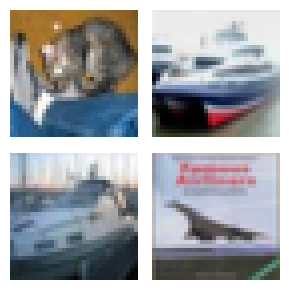

In [24]:
# FOLLOWING ARE THE SALIENCY MAPS


# just plot some example images
some_imgs = tf.convert_to_tensor(test_images[:4])

plt.figure(figsize=(3, 3))
for ind, img in enumerate(some_imgs):
    plt.subplot(2, 2, ind + 1)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# as discussed in the class: mask out logits to keep only the ones we need!
# here: using the true labels
model(some_imgs) * tf.one_hot(test_labels.reshape(-1)[:4], depth=10)

In [ ]:
# could also be using predictions, e.g.
tf.argmax(model(some_imgs), axis=-1)  # then turn to one-hot

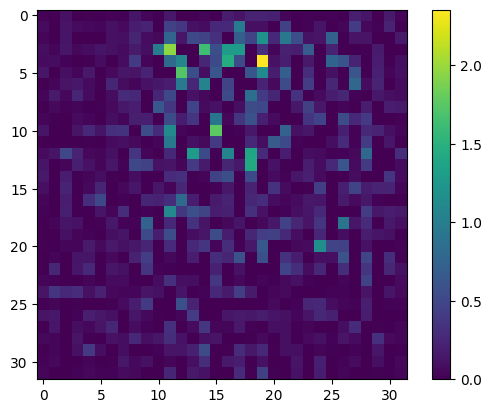

In [25]:
# basic saliency maps!

with tf.GradientTape() as tape:
    tape.watch(some_imgs)
    some_labels = tf.one_hot(test_labels[:4], depth=10)
    logits = model(some_imgs) * some_labels

grads = tape.gradient(logits, some_imgs).numpy()

# in practice, we often just care about positive contributions, so we remove negative values
grads_clip = np.where(grads >= 0, grads, 0)

# if we have multi-channel images, average channels
# no need to do this if you have e.g. MNIST as data
grads_mean = grads_clip.mean(axis=-1)

plt.imshow(grads_mean[0])
plt.colorbar()

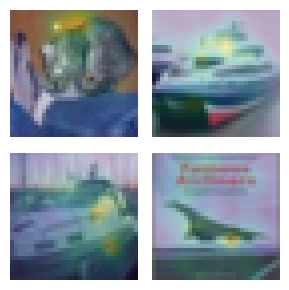

In [26]:

import scipy.ndimage

some_imgs = tf.convert_to_tensor(test_images[:4])

plt.figure(figsize=(3, 3))
for ind, (img, grad) in enumerate(zip(some_imgs, grads)):
    plt.subplot(2, 2, ind + 1)
    plt.imshow(img)
    grad_clip = np.where(grad>0, grad, 0).mean(axis=-1)
    # in addition, slightly blur gradients to reduce noise
    grad_clip = scipy.ndimage.gaussian_filter(grad_clip, 2)

    plt.imshow(grad_clip, alpha=0.3)
    plt.axis("off")
    #plt.colorbar()
plt.tight_layout()
plt.show()

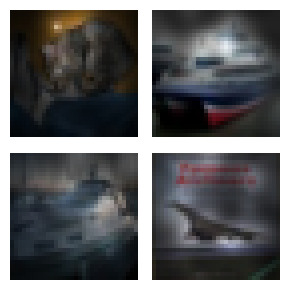

In [27]:
some_imgs = tf.convert_to_tensor(test_images[:4])

plt.figure(figsize=(3, 3))
for ind, (img, grad) in enumerate(zip(some_imgs, grads)):
    plt.subplot(2, 2, ind + 1)
    #plt.imshow(img)
    grad_clip = np.where(grad>0, grad, 0)
    grad_clip = grad_clip.mean(axis=-1, keepdims=True)
    grad_clip = scipy.ndimage.gaussian_filter(grad_clip, 2)

    # silly alternative idea: normalize gradients to [0, 1]
    # then multiply with images -> "lights up" important regions
    grad_clip /= grad_clip.max()
    img_scaled = grad_clip * img
    plt.imshow(img_scaled)

    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# to do activation maximization:

# - choose some target activation (could be logits for a certain class, or activations of a certain hidden neuron, or...)
# - start from a *random* image
# - compute gradients aka saliency maps, NO post-processing
# - add gradients*learning_rate to the image
# - repeat for many steps -> gradient ascent to create an image that maximally activates the network
#   - after every step, should clip images to [0, 1], since gradient descent doesn't know it should stay in that boundary
# - in practice, needs regularization to look good (check e.g. distill article)

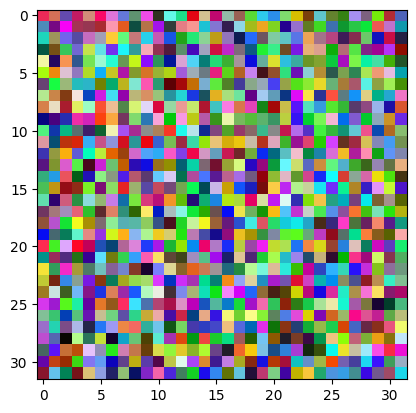

In [29]:
random_imgs = np.random.random([4, 32, 32, 3])
plt.imshow(random_imgs[0])

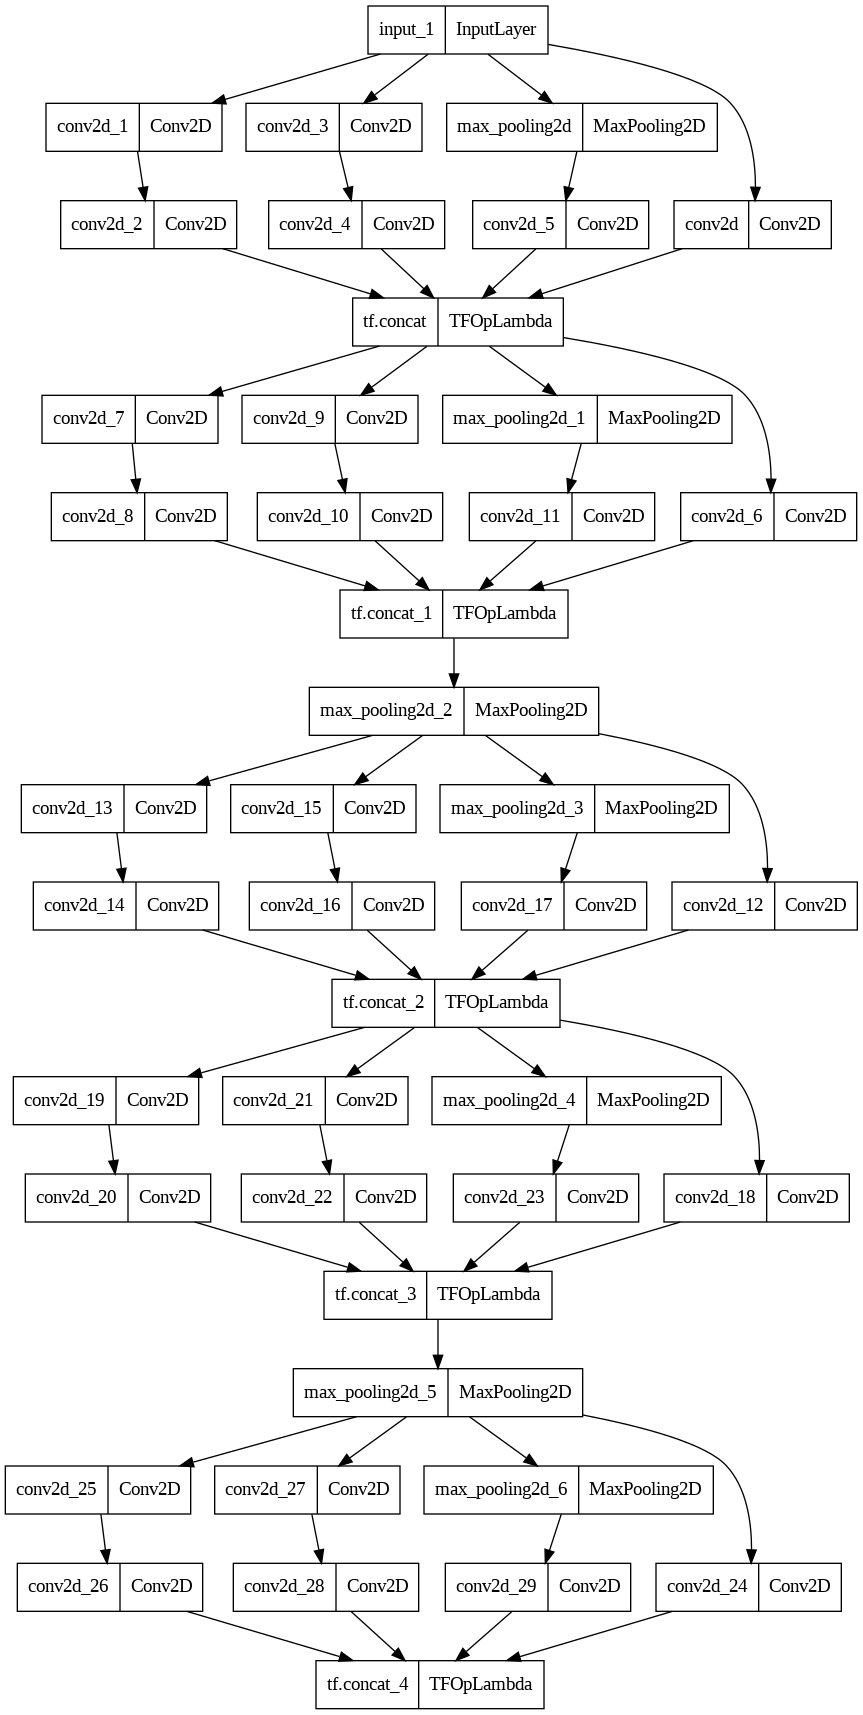

In [32]:
layer_name = 'tf.concat_4'
layer_output = model.get_layer(layer_name).output
submodel = tf.keras.Model(inputs = model.input, outputs = layer_output)

tf.keras.utils.plot_model(submodel)

In [51]:
def loss_function(imgs, model):
  sublogits = model(imgs)

  loss = []
  for i  in sublogits:
    losses =  tf.math.reduce_mean(i)
    loss.append(losses)
  return tf.reduce_sum(loss)

In [52]:
img=tf.convert_to_tensor(random_imgs)



In [53]:
steps=50
step_size=0.01
loss = tf.constant(0.0)
for n in tf.range(steps):
  with tf.GradientTape() as tape:
    # This needs gradients relative to `img`
    # `GradientTape` only watches `tf.Variable`s by default

    tape.watch(img)
    loss = loss_function(img, submodel)

    # Calculate the gradient of the loss with respect to the pixels of the input image.
    gradients = tape.gradient(loss, img)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8

    # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
    # You can update the image by directly adding the gradients (because they're the same shape!)
    img = img + gradients*step_size
    img = tf.clip_by_value(img, 0, 1)



In [54]:
inter_result = 255*(img + 1.0)/2.0
result = tf.cast(inter_result, tf.uint8)

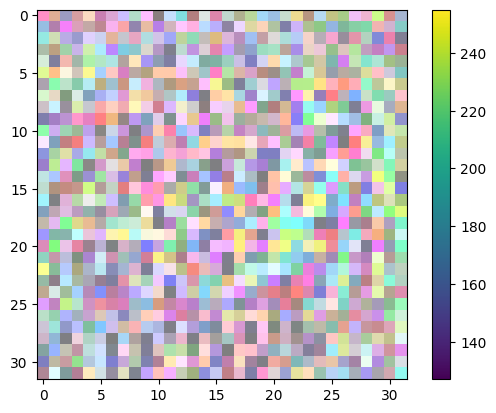

In [58]:
plt.imshow(result[0])
plt.colorbar()